# Chebyshev補間の積分

Chebyshev多項式の有限和で表される関数を**Chebyshev補間**という。[Chebyshev補間の微分](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/Chebdiff.html)の逆操作として、積分もできる（文献 1）。
第1種Chebyshev多項式が $T_n(x)=\cos n\theta$ $(x=\cos\theta)$ であるので、

$$
\begin{align*}
\int T_n(x)dx&=\int -\cos n\theta\sin\theta d\theta \\
&=-\frac{1}{2}\int(\sin (n+1)\theta-\sin (n-1)\theta)d\theta \\
&=\frac{1}{2}\left[\frac{\cos (n+1)\theta}{n+1}-\frac{\cos (n-1)\theta}{n-1}\right]\\
&=\frac{1}{2}\left[\frac{T_{n+1}(x)}{n+1}-\frac{T_{n-1}(x)}{n-1}\right].
\end{align*}
$$

よって積分による定数倍を除けば、

$$
\begin{align*}
\int T_n(x)dx=\begin{cases}
\frac{1}{2}\left[\frac{T_{n+1}(x)}{n+1}-\frac{T_{n-1}(x)}{n-1}\right] & (n\ge 2)\\
\frac14 T_2(x) & (n=1)\\
T_1(x) & (n=0).
\end{cases}
\end{align*}
$$

そしてChebyshev補間

$$p(x)=\sum^{M-1}_{n=0}a_nT_n(x)$$

に対して、不定積分

$$
\begin{align*}
I(x)=\int p(x)dx &= \int \sum_{n=0}^{M-1}a_nT_n(x)dx\\
&=C +a_0T_1(x)+\frac{1}{4}a_1T_2(x)+\sum^{M-1}_{n=2}\frac{a_n}{2}\left[\frac{T_{n+1}(x)}{n+1}-\frac{T_{n-1}(x)}{n-1}\right] \\
&=\sum^{M}_{n=0}A_nT_n(x)
\end{align*}
$$

の係数 $(A_n)_{0\le n \le M}$ を求める。上の式から

$$
A_0 = C,\quad A_1=a_0-\frac{a_2}2,\quad A_n = \frac{a_{n-1}-a_{n+1}}{2n}\quad (n>1),\quad a_{M}=a_{M+1}=0.
$$

**注**　最初の項 $A_0$ は積分定数である。さらに、$A_1$ は $a_0'=2a_0$ とおいて上式を $n=1$ から計算したほうが、実装がきれいになる。

In [1]:
versioninfo()

Julia Version 1.8.3
Commit 0434deb161e (2022-11-14 20:14 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.3.0)
  CPU: 10 × Apple M1 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores


In [2]:
function chebindefint(a; I=[-1,1])# Input is Two-sided
    M = length(a)
    a_ext = zeros(M+2)
    a_ext[1] = 2*a[1]
    a_ext[2:M] = a[2:M]
    A = zeros(M+1)
    for n = 1:M
        A[n+1] = (a_ext[n] - a_ext[n+2])/(2n)
    end
    # A[1] = sum(A[2:2:end]) - sum(A[3:2:end]) # takes the value 0 at the left endpoint
    return A * (I[2]-I[1])/2
end

chebindefint (generic function with 1 method)

この関数 `chebindefint` を用いて、$e^{x}$ のChebyshev補間を不定積分し、各係数を比較する。積分定数を一つに決定するため、`chebindefint` 関数では積分平均が0になるように出力する。

In [3]:
include("FourierChebyshev.jl")
f(x) = exp(x)
a = cheb(f)
A = chebindefint(a)
reshape([[a;0];A],length(A),2)

15×2 Matrix{Float64}:
 1.26607      0.0
 1.13032      1.13032
 0.271495     0.271495
 0.0443368    0.0443368
 0.00547424   0.00547424
 0.000542926  0.000542926
 4.49773e-5   4.49773e-5
 3.19844e-6   3.19844e-6
 1.99212e-7   1.99212e-7
 1.10368e-8   1.10368e-8
 5.5059e-10   5.5059e-10
 2.49796e-11  2.49795e-11
 1.0404e-12   1.03916e-12
 3.98997e-14  4.00153e-14
 0.0          1.42499e-15

定数項（ゼロモード）は違うが、それ以降は同じ係数が出力されている。もう一つ見やすい例で $f(x)=2 e^{-x^2}/\sqrt{\pi}$ として、その積分平均0の不定積分は誤差関数

$$
\mathrm{erf}(x) = \frac{2}{\sqrt{\pi}}\int_0^x e^{-t^2} dt
$$

となる。

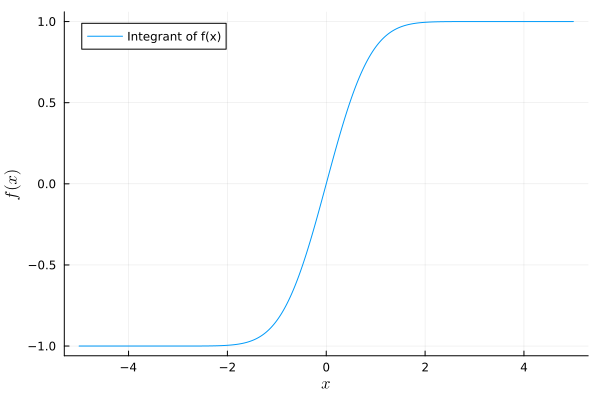

In [4]:
f(x) = 2*exp(-x^2)/sqrt(π); dom = [-5,5]
a = cheb(f,dom)
plot_cheb(chebindefint(a,I=dom),I=dom,label="Integrant of f(x)")

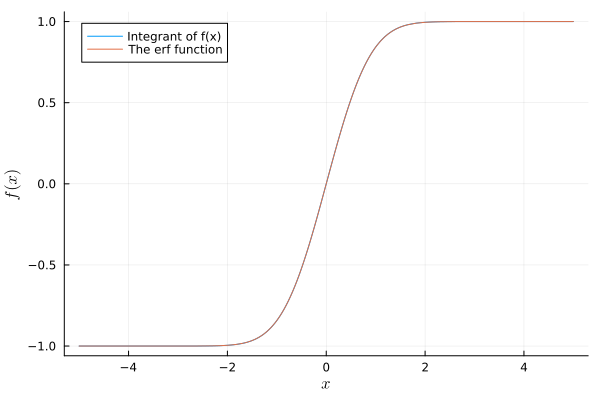

In [5]:
using SpecialFunctions
plot!(x->erf(x),-5,5,label="The erf function")

### 不定積分の精度保証付き数値計算

上記操作の区間演算版を実装することで、Chebyshev補間の不定積分（積分平均が0になる）を精度保証付きで実装することもできる。

In [6]:
using IntervalArithmetic
function chebindefint(ia::Vector{Interval{T}}; I=[-1,1])where T # Input is Two-sided (inverval)
    M = length(ia)
    ia_ext = zeros(Interval{T},M+2)
    ia_ext[1] = 2*ia[1]
    ia_ext[2:M] = ia[2:M]
    iA = zeros(Interval{T},M+1)
    for n = 1:M
        iA[n+1] = (ia_ext[n] - ia_ext[n+2])/(2n)
    end
    # A[1] = sum(A[2:2:end]) - sum(A[3:2:end]) # takes the value 0 at the left endpoint
    return iA * (interval(I[2])-I[1])/2
end

chebindefint (generic function with 2 methods)

In [7]:
maximum(radius,chebindefint(interval.(a)))

5.551115123125783e-17

## Clenshaw–Curtis型数値積分公式による定積分

区間 $I=[-1,1]$ 上で与えられたChebyshev補間

$$p_{M-1}(x)=\sum^{M-1}_{n=0}a_nT_n(x)$$

に対して、定積分

$$I_M=\int_{-1}^1 p_{M-1}(x) dx$$

を計算する方法を考える。有名な数値積分公式であるGauss型数値積分公式がLegendre点（ルジャンドル多項式の零点）を積分点にとることに対して、**Clenshaw–Curtis（クレンショウ-カーティス）型数値積分公式**はChebyshev点を積分点にとる。そして被積分関数が $M-1$ 次多項式であるとき、$M$ 点のClenshaw–Curtis型数値積分公式は厳密な積分値を与えることが知られている（文献 2 定理19.1）。

ここでは、数値解析の講義のような数値積分公式の紹介は置いておいて、Chebyshev補間の定積分の方法に焦点を当てる。次数 $n$ のChebyshev多項式を区間 $[-1,1]$ で積分すると、

$$
\begin{align*}
\int_{-1}^1 T_n(x)dx &= \frac{1}{2}\left[\frac{T_{n+1}(x)}{n+1}-\frac{T_{n-1}(x)}{n-1}\right]_{x=-1}^{x=1}\\[2mm]
&= \frac{1-(-1)^{n+1}}2\left(\frac1{n+1}-\frac1{n-1}\right)\\[2mm]
&= \begin{cases}
0, & n:~\mbox{odd}\\[2mm]
\displaystyle\frac2{1-n^2}, & n:~\mbox{even}
\end{cases}
\end{align*}
$$

であるから、Chebyshev補間の定積分は次のように計算できる（文献 2 定理19.2）。

$$
\int_{-1}^1 p_{M-1}(x) dx = \int_{-1}^1 \sum^{M-1}_{n=0}a_nT_n(x)dx = \sum_{n=0\atop n: \tiny\mbox{even}}^{M-1}\frac{2a_n}{1-n^2}.
$$

In [8]:
function chebint(a; I=[-1,1])# Input is Two-sided
    M = length(a)
    n = 0:2:M-1
    return sum(2a[1:2:end]./(1.0 .- n.^2))*((I[2]-I[1])/2)
end

chebint (generic function with 1 method)

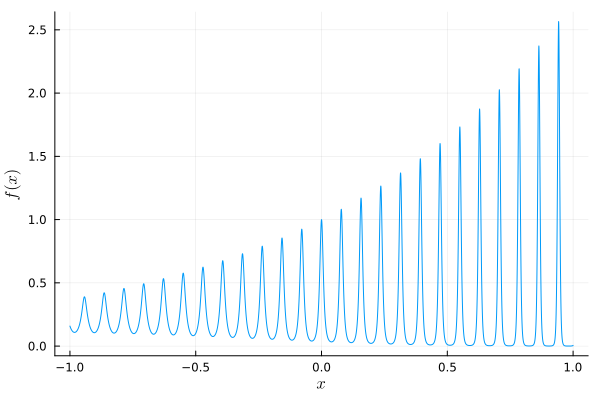

In [9]:
# f(x) = exp(x); dom = [0,1]
# f(x) = exp(-100x.^2); dom = [-1,1]
# f(x) = 1/(1+1000*(x+.5)^2)+1/sqrt(1+1000*(x-.5)^2); dom = [-1,1]
# f(x) = exp(erf(x^2)+x.^5).*sin(3*pi*x) + x; dom = [-1.5,1.1]
f(x) = exp(x)*sech(4*sin(40*x))^exp(x); dom = [-1,1]
a = cheb(f, dom)
plot_cheb(a, I=dom)

In [10]:
chebint(a, I=dom)

0.5433840009079002

### 定積分の精度保証付き数値計算

不定積分の場合と同様、区間演算版を実装することで、Chebyshev補間の定積分が精度保証付き数値計算できる。

**注**　`cheb`関数を用いてChebyshev補間を得る際の誤差を評価してないので、関数の定積分を精度保証付き数値計算できているわけでは無い。しかし、Chebyshev補間で与えられる関数の定積分はこの方法で精度保証付き数値計算できている。

In [11]:
function chebint(ia::Vector{Interval{T}}; I=[-1,1])where T # Input is Two-sided (inverval)
    M = length(ia)
    n = 0:2:M-1
    return sum(2ia[1:2:end]./(1.0 .- interval.(n).^2))*((interval(I[2])-I[1])/2)
end

chebint (generic function with 2 methods)

In [12]:
chebint(map(interval,a))

[0.543384, 0.543385]

本資料は以下のような文献・Web ページ等を参考に書いています。

### 参考文献

1.  J.C. Mason and D.C. Handscomb, Chebyshev Polynomials (1st ed.), Chapman and Hall/CRC, 2002.<br>
(2.4.4章に積分操作の説明がある。この本はチェビシェフ多項式をもの凄く詳しく説明している教科書で辞書的に調べる使い方で無敵を誇る)

1. Lloyd N. Trefethen, Approximation Theory and Approximation Practice, Extended Edition, SIAM, 2019.<br>
(補間理論のマニアックな教科書、19章にClenshaw–Curtis型数値積分公式の説明とGauss型数値積分公式の関係を議論している。Chebfunを使って実例を見せながら理解させる書き方はとても面白く、分かりやすい)

<div align="right"><a href="http://www.risk.tsukuba.ac.jp/~takitoshi/">高安亮紀</a>, 2023年2月28日</div>